<a href="https://colab.research.google.com/github/Sneha2124/PPE-Kit-Detection-Using-ML/blob/main/ML_MINI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install super-gradients #installing packages
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
from super_gradients.training import Trainer #installing libraries
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

The console stream is logged into /root/sg_logs/console.log


[2023-10-26 14:52:54] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-10-26 14:52:55] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-10-26 14:53:00] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-10-26 14:53:02] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-10-26 14:53:02] WARNING - export.py - Failed to import pytorch_quantization
[2023-10-26 14:53:02] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
from IPython.display import clear_output

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [ ]:
from super_gradients.training import models

In [ ]:
CHECKPOINT_DIR = 'checkpoints2'  #checkpoint dicrectory
trainer = Trainer(experiment_name='ppe_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
!pip install roboflow
#dataset
from roboflow import Roboflow
rf = Roboflow(api_key="IuYv6KOKs5p62rFSLvGa")
project = rf.workspace("objet-detect-yolov5").project("eep_detection-u9bbd")
dataset = project.version(1).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to EEP_Detection-1 in yolov5pytorch:: 100%|██████████| 6482/6482 [00:00<00:00, 7606.54it/s]


In [ ]:
dataset_params = {
    'data_dir':'/content/EEP_Detection-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Protective Helmet', 'Shield', 'Jacket', 'Dust Mask', 'Eye Wear', 'Glove', 'Protective Boots']
}
#loading dataset parameters in dictionary

In [ ]:
#passing values od dataset parameters to dataset arguments
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 324/324 [00:00<00:00, 2438.48it/s]


In [ ]:
train_data.dataset.transforms #inspecting dataset

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

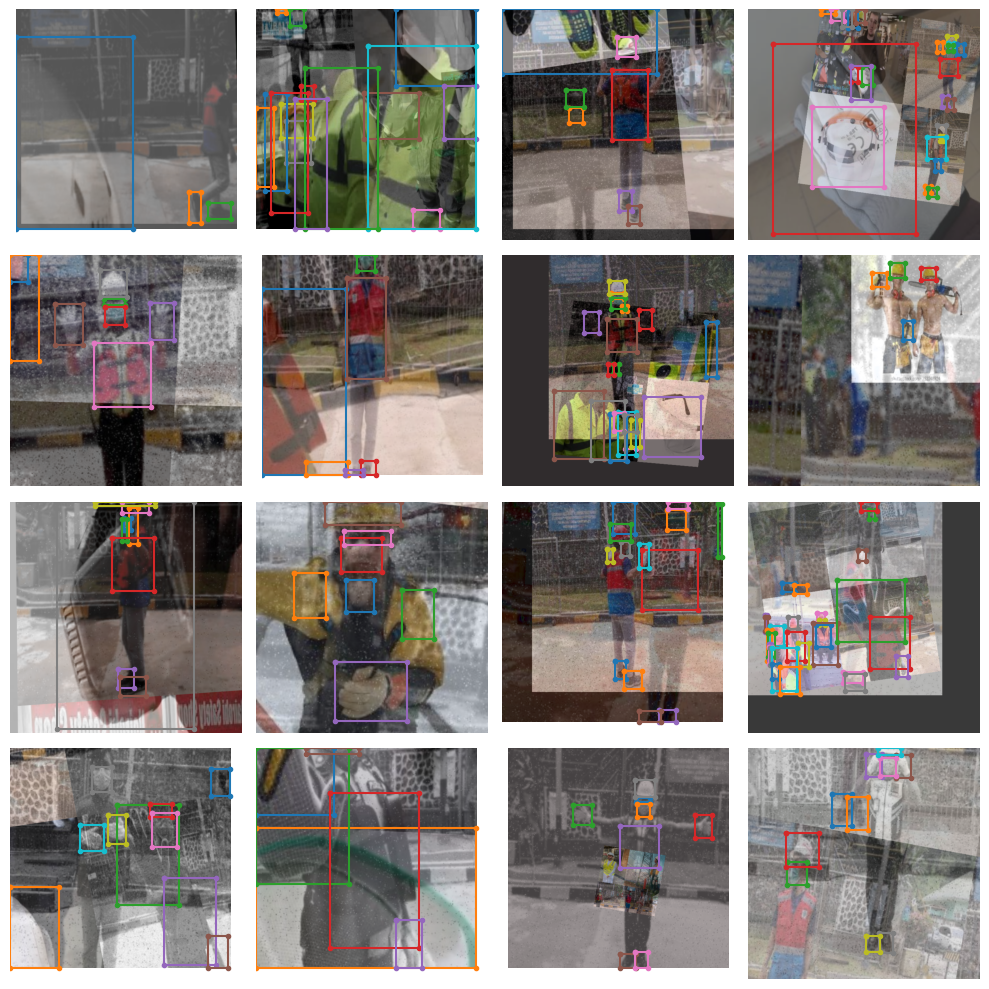

In [ ]:
train_data.dataset.plot()  #plotting dataset

In [ ]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )
#instantiate model

[2023-10-26 14:58:06] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 81.8MB/s]
[2023-10-26 14:58:07] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}
#definig metrics and training parameters

In [ ]:
!gdown "https://drive.google.com/uc?id=1crFwrpMF1OlaJ0ZCZjBNRo9llLEVR8VQ&confirm=t" #downloading videos

Downloading...
From: https://drive.google.com/uc?id=1crFwrpMF1OlaJ0ZCZjBNRo9llLEVR8VQ&confirm=t
To: /content/demo.mp4
100% 42.9M/42.9M [00:00<00:00, 49.2MB/s]


In [ ]:
!gdown "https://drive.google.com/uc?id=1cTIBNQ1R_7JAOURVv9cJ6P935ym_IkZ0&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1cTIBNQ1R_7JAOURVv9cJ6P935ym_IkZ0&confirm=t
To: /content/demo3.mp4
100% 20.3M/20.3M [00:00<00:00, 54.9MB/s]


In [ ]:
!gdown "https://drive.google.com/uc?id=1256pNK0nQnEDT6FRLQAraTRkOY7BSprq&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1256pNK0nQnEDT6FRLQAraTRkOY7BSprq&confirm=t
To: /content/demo4.mp4
100% 16.9M/16.9M [00:00<00:00, 53.9MB/s]


In [ ]:
!gdown "https://drive.google.com/uc?id=15D71z_g8uxZfXSx2ya3sy4n2-eg53meH&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=15D71z_g8uxZfXSx2ya3sy4n2-eg53meH&confirm=t
To: /content/demonew.mp4
100% 5.39M/5.39M [00:00<00:00, 31.1MB/s]


In [ ]:
!gdown "https://drive.google.com/uc?id=1iYW9ZAsYAaHkWZhFVwQh_ch41TMt30-Q&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1iYW9ZAsYAaHkWZhFVwQh_ch41TMt30-Q&confirm=t
To: /content/demonew2.mp4
100% 1.87M/1.87M [00:00<00:00, 13.3MB/s]


In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)
#model training

[2023-10-26 14:59:33] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231026_145933_265373`
[2023-10-26 14:59:33] INFO - sg_trainer.py - Checkpoints directory: checkpoints2/ppe_yolonas_run2/RUN_20231026_145933_265373
[2023-10-26 14:59:33] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints2/ppe_yolonas_run2/RUN_20231026_145933_265373/console_Oct26_14_59_33.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
[2023-10-26 14:59:37] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2264       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         141        (len(train_loader))
    - Gradient updates per epoch:   141        (len(train_loader) / batch_accumulate)

[2023-10-26 15:02:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20231026_145933_265373/ckpt_best.pth
[2023-10-26 15:02:29] INFO - sg_trainer.py - Best checkpoint ov

In [ ]:
#choicing best model
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints2/ppe_yolonas_run2/RUN_20231026_145933_265373/ckpt_best.pth")

[2023-10-26 15:30:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints2/ppe_yolonas_run2/RUN_20231026_145933_265373/ckpt_best.pth EMA checkpoint.


In [ ]:
#evaluating best model
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))


Testing: 100%|██████████| 21/21 [00:09<00:00,  3.00it/s]

{'PPYoloELoss/loss_cls': 0.7757567,
 'PPYoloELoss/loss_iou': 0.1615264,
 'PPYoloELoss/loss_dfl': 0.86167467,
 'PPYoloELoss/loss': 1.6104103,
 'Precision@0.50': 0.05659403279423714,
 'Recall@0.50': 0.9767482876777649,
 'mAP@0.50': 0.7811049222946167,
 'F1@0.50': 0.10479121655225754}

Testing: 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


[2023-10-26 15:32:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


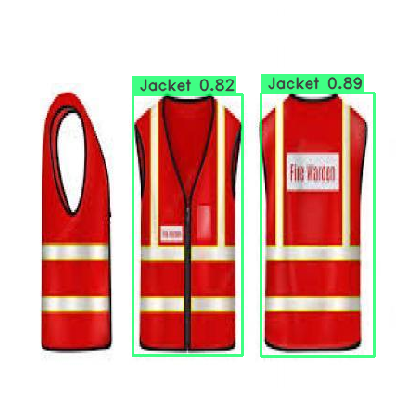

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


In [ ]:
#predicting best model
img_url = '/content/EEP_Detection-1/test/images/65_jpg.rf.8f24e83e9784a158d23e14accf74f83c.jpg'
best_model.predict(img_url).show()

In [ ]:
#testing
input_video_path = f"/content/demonew2.mp4"
output_video_path = "detections.mp4"

In [ ]:
#testing
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
#testing
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 65/65 [00:06<00:00, 10.32it/s]
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


In [ ]:
#displaying output
!rm '/content/result_compressed.mp4'

In [ ]:
#displaying output
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""

# """ % data_url)
from IPython.display import HTML

# Assuming 'data_url' contains the base64-encoded video data
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# Use the correct HTML syntax to embed the video
HTML(f'<video controls src="{data_url}">Your browser does not support the video tag</video>')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
